#### Biblioteki

In [88]:
# Biblioteki ogólne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Scikit-learn: przetwarzanie danych i modele
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV, 
                                     cross_validate, StratifiedKFold, cross_val_score, learning_curve, validation_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, brier_score_loss, confusion_matrix,
                             precision_recall_curve, roc_curve, average_precision_score)
# Imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier

# Skopt do optymalizacji bayesowskiej
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from scipy.stats import randint

# API NBA
from nba_api.stats.endpoints import leaguegamefinder


### Pobieranie danych

In [ ]:
print("=== Pobieranie danych NBA ===")
  
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2022-23')  
games = gamefinder.get_data_frames()[0]  

print(games.head()) 

=== Pobieranie danych NBA ===
  SEASON_ID     TEAM_ID TEAM_ABBREVIATION       TEAM_NAME     GAME_ID  \
0     42022  1610612743               DEN  Denver Nuggets  0042200405   
1     42022  1610612748               MIA      Miami Heat  0042200405   
2     42022  1610612743               DEN  Denver Nuggets  0042200404   
3     42022  1610612748               MIA      Miami Heat  0042200404   
4     42022  1610612748               MIA      Miami Heat  0042200403   

    GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  REB  AST  \
0  2023-06-12  DEN vs. MIA  W  240   94  ...   0.565    11    46   57   21   
1  2023-06-12    MIA @ DEN  L  240   89  ...   0.875    11    33   44   18   
2  2023-06-09    DEN @ MIA  W  242  108  ...   0.762     5    29   34   26   
3  2023-06-09  MIA vs. DEN  L  240   95  ...   0.850     8    29   37   23   
4  2023-06-07  MIA vs. DEN  L  240   94  ...   0.789    10    23   33   20   

   STL  BLK  TOV  PF  PLUS_MINUS  
0    6    7   14  13       

### Przygotowanie danych

In [90]:
print("\n=== Przygotowanie danych ===")

# Wybór istotnych kolumn i tworzenie nowych cech
features = ['PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
            'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
            'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']

# Tworzenie datasetu z informacją kto wygrał
games_clean = games.copy()
games_clean['WL'] = games_clean['WL'].apply(lambda x: 1 if x == 'W' else 0)

# Grupowanie danych po meczach
home = games_clean[games_clean['MATCHUP'].str.contains('vs.')].sort_values('GAME_DATE')
away = games_clean[games_clean['MATCHUP'].str.contains('@')].sort_values('GAME_DATE')

# Łączenie statystyk drużyn dla każdego meczu
home_stats = home[features]
away_stats = away[features]

# Różnice w statystykach między drużynami
diff_stats = home_stats.reset_index(drop=True) - away_stats.reset_index(drop=True)
diff_stats['WL'] = home['WL'].reset_index(drop=True)  # Czy gospodarz wygrał

# Tworzenie dodatkowych cech
diff_stats['EFF'] = (diff_stats['PTS'] + diff_stats['REB'] + diff_stats['AST'] + 
                    diff_stats['STL'] + diff_stats['BLK'] - diff_stats['TOV'])
diff_stats['AST_TOV'] = diff_stats['AST'] / (diff_stats['TOV'] + 1)  
diff_stats['STL_TOV'] = diff_stats['STL'] / (diff_stats['TOV'] + 1)
diff_stats['FG3_PCT_DIFF'] = diff_stats['FG3_PCT'] - diff_stats['FG_PCT']

# Usuwanie brakujących wartości
diff_stats.replace([np.inf, -np.inf], np.nan, inplace=True)
diff_stats.dropna(inplace=True)


=== Przygotowanie danych ===


### Eksploracyjna analiza danych

In [91]:
print("\n=== Eksploracyjna analiza danych ===")


=== Eksploracyjna analiza danych ===


#### Analiza rozkładu cech

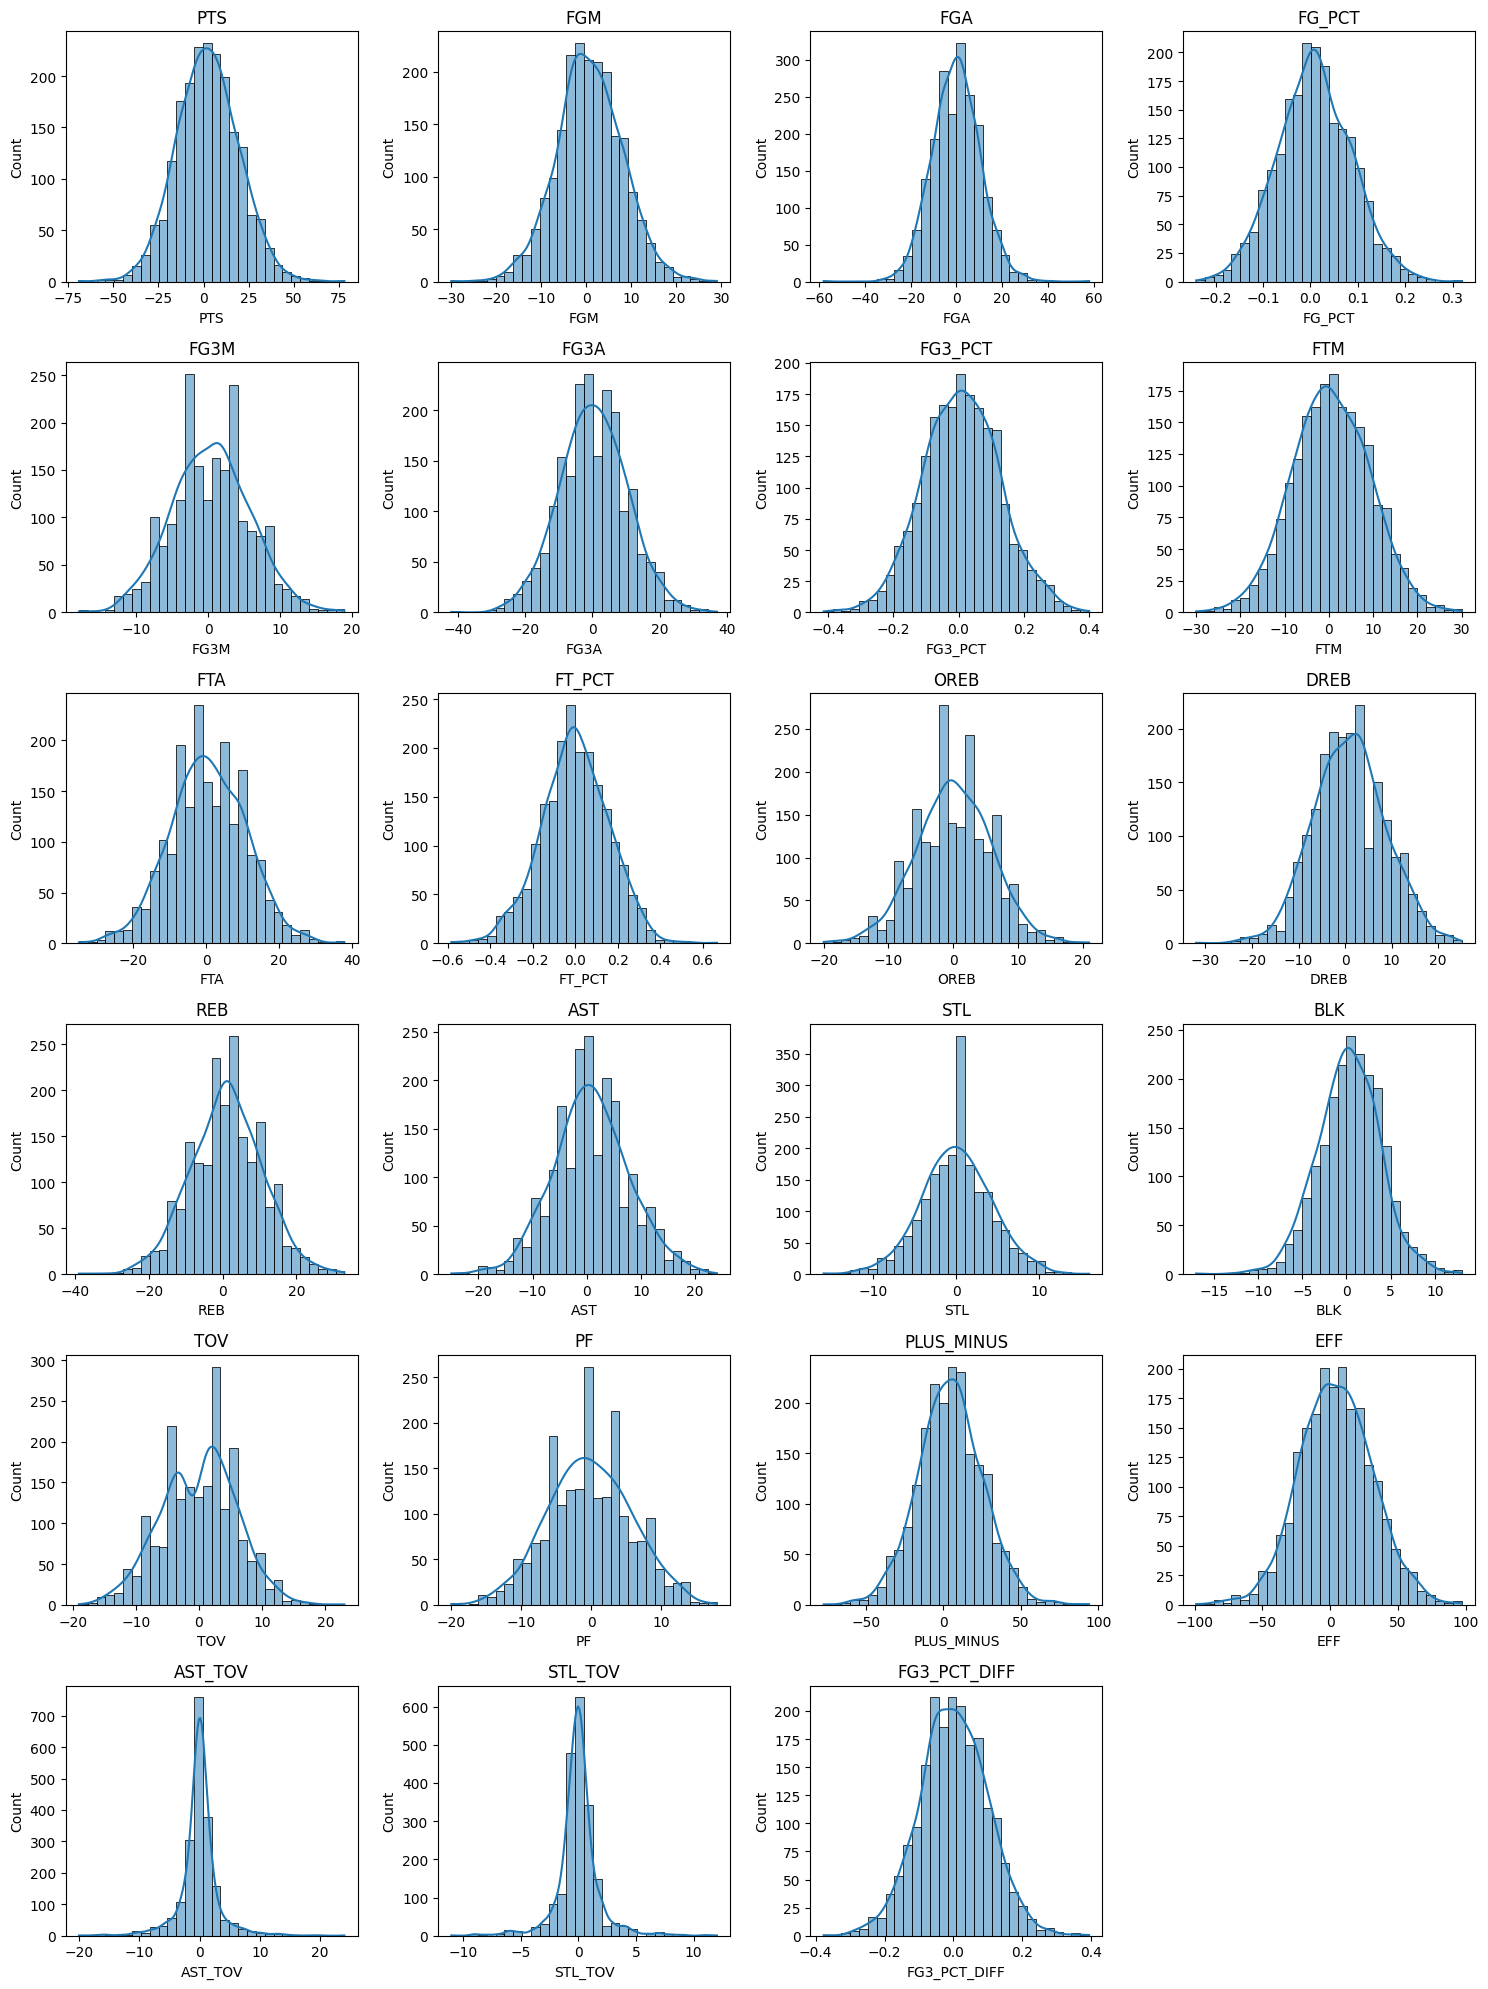

In [92]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(diff_stats.drop('WL', axis=1).columns):
    plt.subplot(6, 4, i+1)
    sns.histplot(diff_stats[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

#### Analiza outlierów

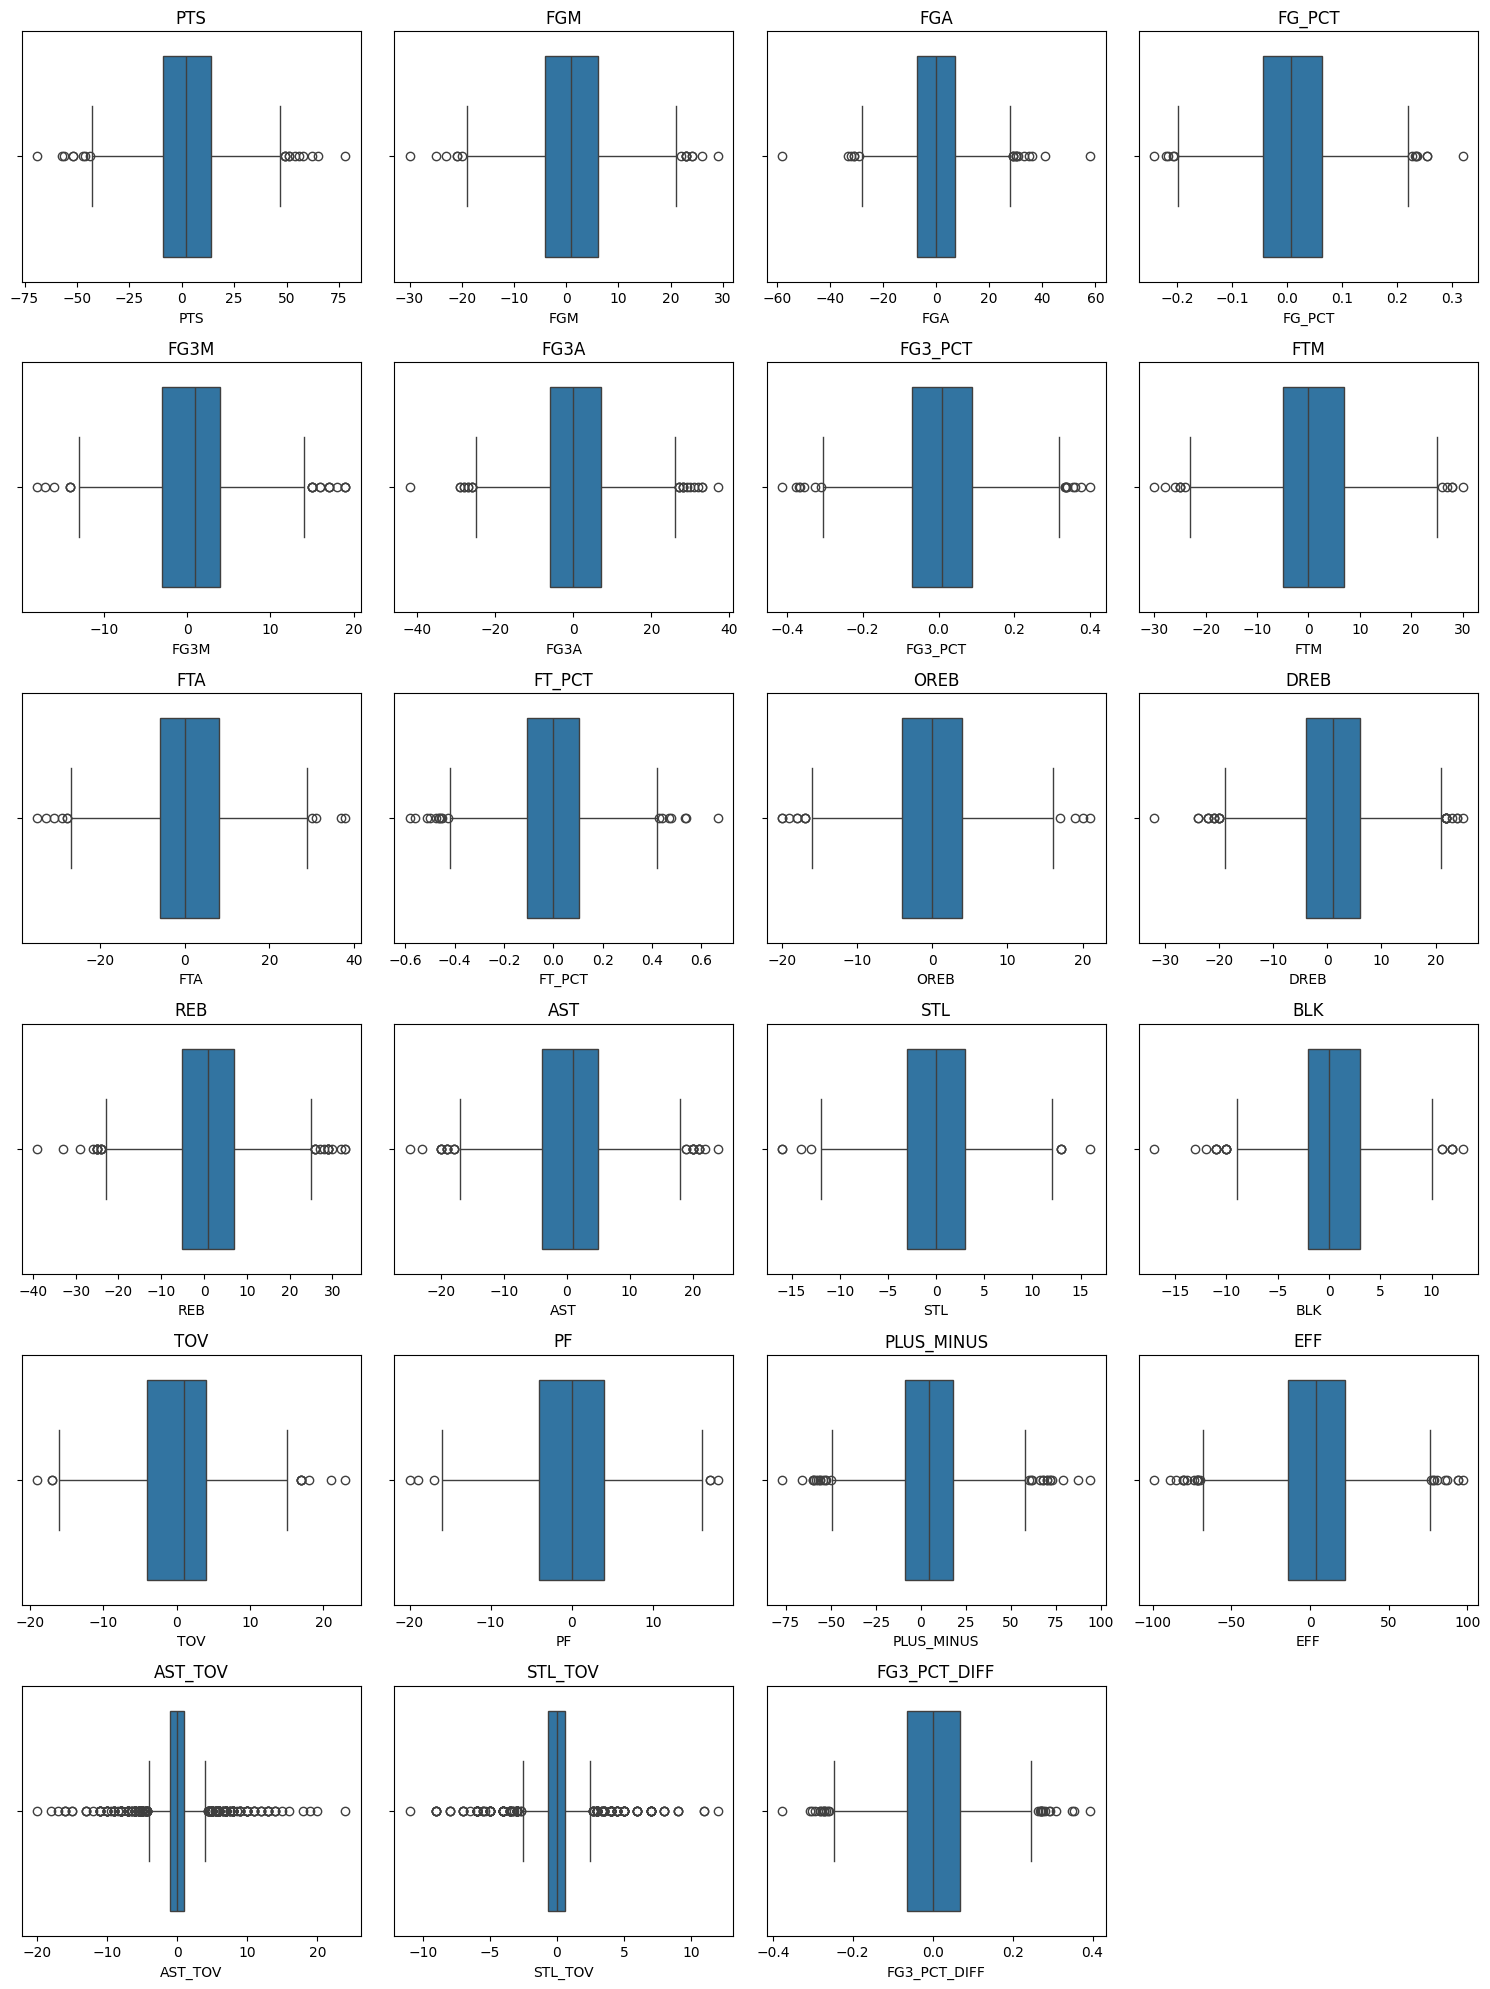

In [93]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(diff_stats.drop('WL', axis=1).columns):
    plt.subplot(6, 4, i+1)
    sns.boxplot(x=diff_stats[col])
    plt.title(col)
plt.tight_layout()
plt.show()

#### Analiza PCA

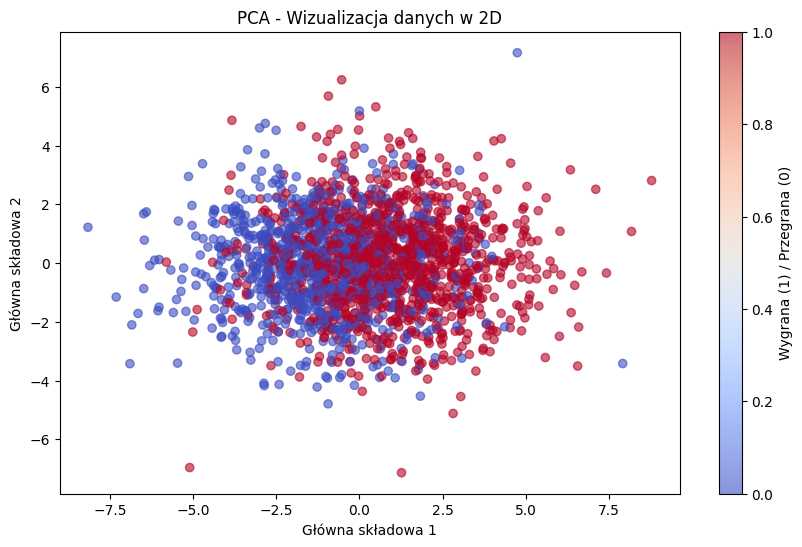

In [94]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(diff_stats.drop('WL', axis=1))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=diff_stats['WL'], alpha=0.6, cmap='coolwarm')
plt.title('PCA - Wizualizacja danych w 2D')
plt.xlabel('Główna składowa 1')
plt.ylabel('Główna składowa 2')
plt.colorbar(label='Wygrana (1) / Przegrana (0)')
plt.show()

#### Analiza korelacji

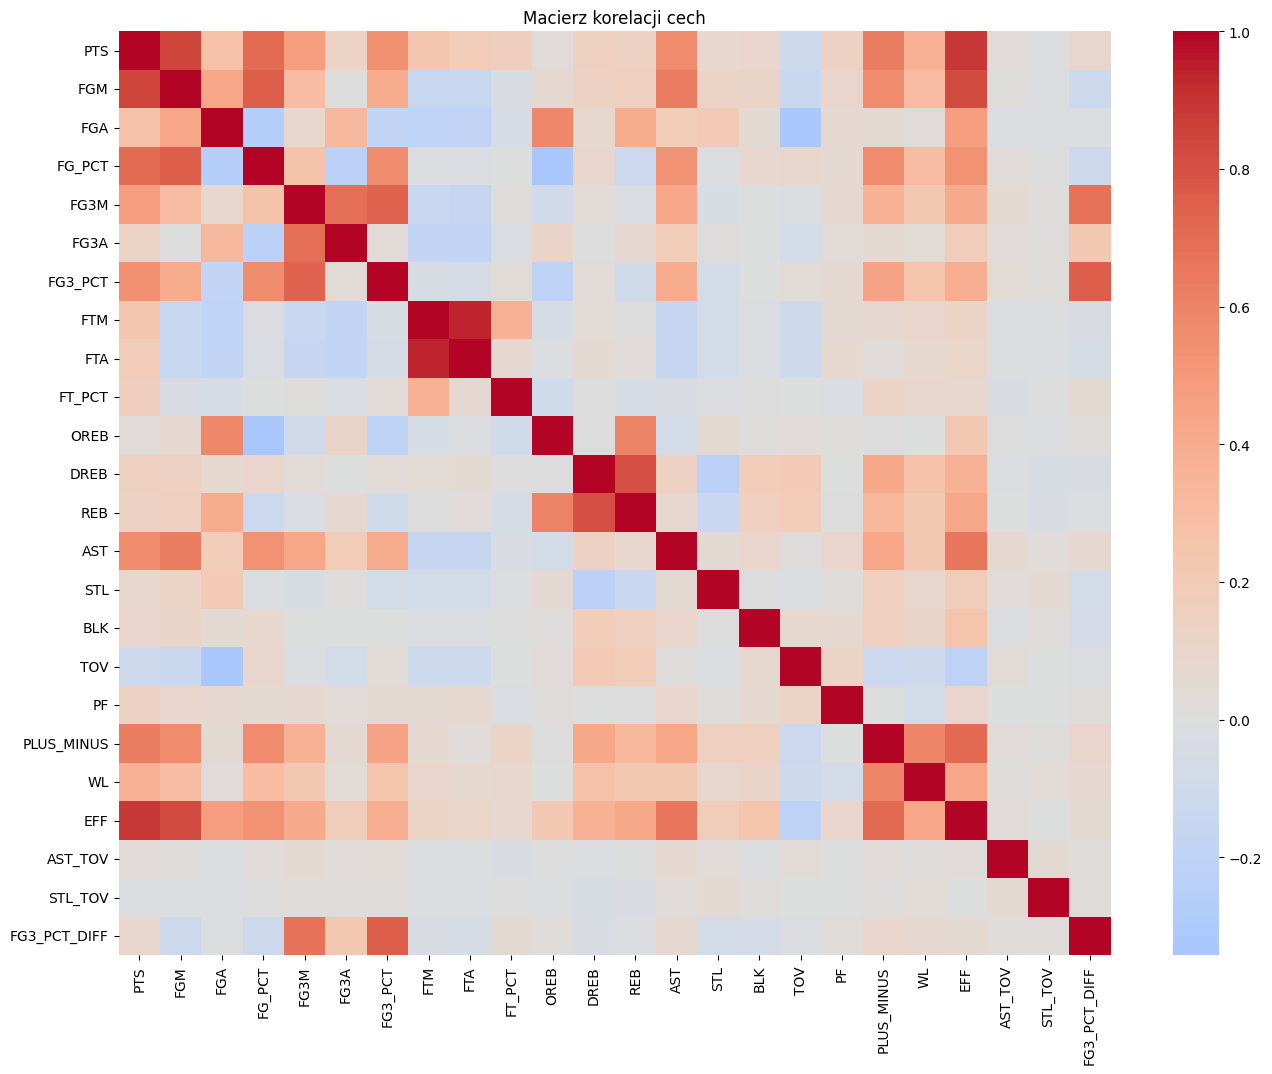

In [95]:
corr_matrix = diff_stats.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Macierz korelacji cech')
plt.show()

##### Najbardziej skorelowane cechy z wynikiem

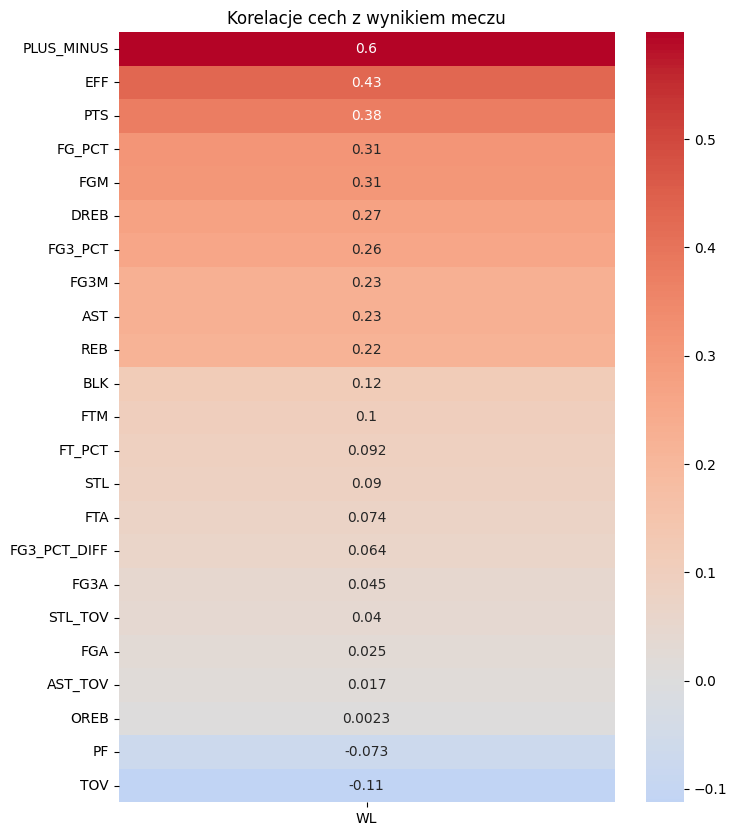

In [96]:
plt.figure(figsize=(8, 10))
sns.heatmap(corr_matrix[['WL']].sort_values('WL', ascending=False)[1:],
            annot=True, cmap='coolwarm', center=0)
plt.title('Korelacje cech z wynikiem meczu')
plt.show()

### Podział danych

In [97]:
X = diff_stats.drop('WL', axis=1)
y = diff_stats['WL']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

### Metryki i walidacja krzyżowa

In [98]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'log_loss': 'neg_log_loss'   
}

# Niestandardowa strategia walidacji krzyżowej
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Budowa potoków przetwarzania

In [99]:
# Potok podstawowy
base_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('variance_threshold', VarianceThreshold(threshold=0.01)),
    ('feature_selector', SelectKBest(score_func=f_classif, k=10)),
])

# Potok z redukcją wymiarowości
pipeline_pca = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
])

# Potok z selekcją cech opartą na modelu
pipeline_model_select = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('feature_selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
])

### Modele i parametry

In [100]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'k-NN': KNeighborsClassifier(),
    'Balanced RF': BalancedRandomForestClassifier(random_state=42)
}

### Optymalizacja hiperparametrów z różnymi metodami

In [101]:
print("\n=== Optymalizacja hiperparametrów różnymi metodami ===")

# Parametry dla GridSearchCV
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Parametry dla RandomizedSearchCV
param_dist_rf = {
    'classifier__n_estimators': randint(50, 500),
    'classifier__max_depth': [None] + list(np.arange(5, 50, 5)),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__max_features': ['sqrt', 'log2', None],
    'preprocessing__feature_selector__k': randint(5, X.shape[1])
}

# Parametry dla BayesSearchCV
bayes_space_rf = {
    'classifier__n_estimators': Integer(50, 500),
    'classifier__max_depth': Integer(5, 50),
    'classifier__min_samples_split': Integer(2, 20),
    'classifier__min_samples_leaf': Integer(1, 10),
    'classifier__max_features': Categorical(['sqrt', 'log2', None]),
    'preprocessing__feature_selector__k': Integer(5, X.shape[1])
}


=== Optymalizacja hiperparametrów różnymi metodami ===


### Funkcja do oceny modelu

In [102]:
def evaluate_model(model, X_train, y_train, X_test, y_test, cv_strategy, scoring):
    print(f"\n=== Ocena modelu {model.__class__.__name__} ===")
    
    # Walidacja krzyżowa
    cv_results = cross_validate(model, X_train, y_train, cv=cv_strategy, scoring=scoring)
    
    print("\nWyniki walidacji krzyżowej:")
    for metric in cv_results:
        if metric.startswith('test_'):
            print(f"{metric[5:]}: {np.mean(cv_results[metric]):.4f} ± {np.std(cv_results[metric]):.4f}")
    
    # Trenowanie i ocena na zbiorze testowym
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    print("\nMetryki na zbiorze testowym:")
    print(f"Czas trenowania: {train_time:.2f}s")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1: {f1_score(y_test, y_pred):.4f}")
    
    if y_proba is not None:
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
        print(f"Log Loss: {log_loss(y_test, y_proba):.4f}")
        print(f"Brier Score: {brier_score_loss(y_test, y_proba):.4f}")
    
    # Macierz pomyłek
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Macierz pomyłek')
    plt.xlabel('Predykcja')
    plt.ylabel('Rzeczywistość')
    plt.xticks([0.5, 1.5], ['Przegrana', 'Wygrana'])
    plt.yticks([0.5, 1.5], ['Przegrana', 'Wygrana'])
    plt.show()
    
    # Krzywa ROC
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Krzywa ROC')
        plt.legend()
        plt.show()
    
    # Krzywa precyzja-recall
    if y_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'AP = {average_precision_score(y_test, y_proba):.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Krzywa Precyzja-Recall')
        plt.legend()
        plt.show()
    
    return model


### Optymalizacja modelu Random Forest różnymi metodami

In [103]:
print("\n=== Optymalizacja Random Forest różnymi metodami ===")

# GridSearchCV
pipeline_rf_grid = Pipeline([
    ('preprocessing', base_pipeline),
    ('classifier', RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(pipeline_rf_grid, param_grid_rf, cv=cv_strategy, 
                          scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("\nNajlepsze parametry (GridSearchCV):", grid_search.best_params_)
print("Najlepszy ROC AUC (GridSearchCV):", grid_search.best_score_)

# RandomizedSearchCV
pipeline_rf_random = Pipeline([
    ('preprocessing', base_pipeline),
    ('classifier', RandomForestClassifier(random_state=42))
])

random_search = RandomizedSearchCV(pipeline_rf_random, param_dist_rf, n_iter=50, 
                                 cv=cv_strategy, scoring='roc_auc', 
                                 n_jobs=-1, random_state=42, verbose=1)
random_search.fit(X_train, y_train)
print("\nNajlepsze parametry (RandomizedSearchCV):", random_search.best_params_)
print("Najlepszy ROC AUC (RandomizedSearchCV):", random_search.best_score_)

# BayesSearchCV
pipeline_rf_bayes = Pipeline([
    ('preprocessing', base_pipeline),
    ('classifier', RandomForestClassifier(random_state=42))
])

bayes_search = BayesSearchCV(pipeline_rf_bayes, bayes_space_rf, n_iter=50, 
                            cv=cv_strategy, scoring='roc_auc', 
                            n_jobs=-1, random_state=42, verbose=1)
bayes_search.fit(X_train, y_train)
print("\nNajlepsze parametry (BayesSearchCV):", bayes_search.best_params_)
print("Najlepszy ROC AUC (BayesSearchCV):", bayes_search.best_score_)


=== Optymalizacja Random Forest różnymi metodami ===
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Najlepsze parametry (GridSearchCV): {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Najlepszy ROC AUC (GridSearchCV): 0.8537135215818775
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Najlepsze parametry (RandomizedSearchCV): {'classifier__max_depth': 5, 'classifier__max_features': None, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 14, 'classifier__n_estimators': 90, 'preprocessing__feature_selector__k': 19}
Najlepszy ROC AUC (RandomizedSearchCV): 0.8615141624783812
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalli

### Ocena najlepszego modelu


=== Ocena modelu Pipeline ===

Wyniki walidacji krzyżowej:
accuracy: 0.7814 ± 0.0117
precision: 0.7969 ± 0.0074
recall: 0.8171 ± 0.0289
f1: 0.8066 ± 0.0139
roc_auc: 0.8626 ± 0.0129
log_loss: -0.4591 ± 0.0214

Metryki na zbiorze testowym:
Czas trenowania: 0.69s
Accuracy: 0.7861
Precision: 0.8062
Recall: 0.8133
F1: 0.8097
ROC AUC: 0.8758
Log Loss: 0.4317
Brier Score: 0.1412


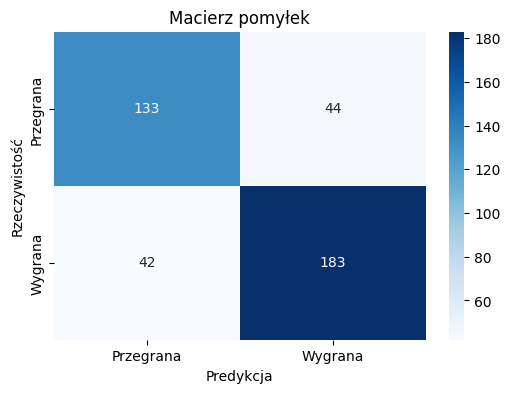

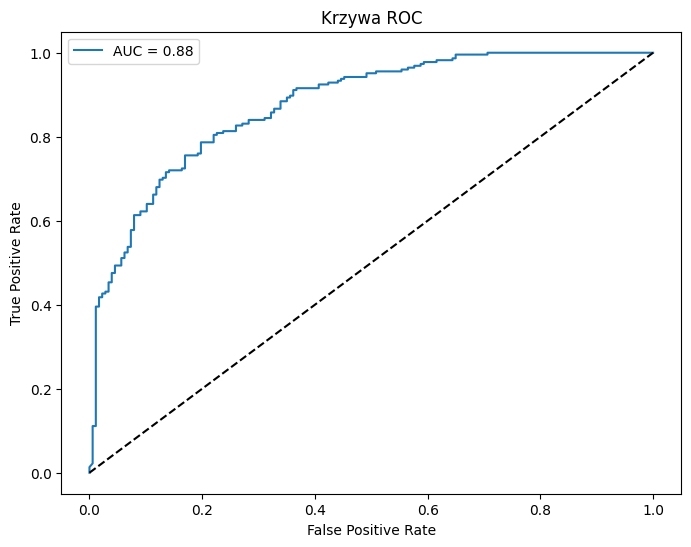

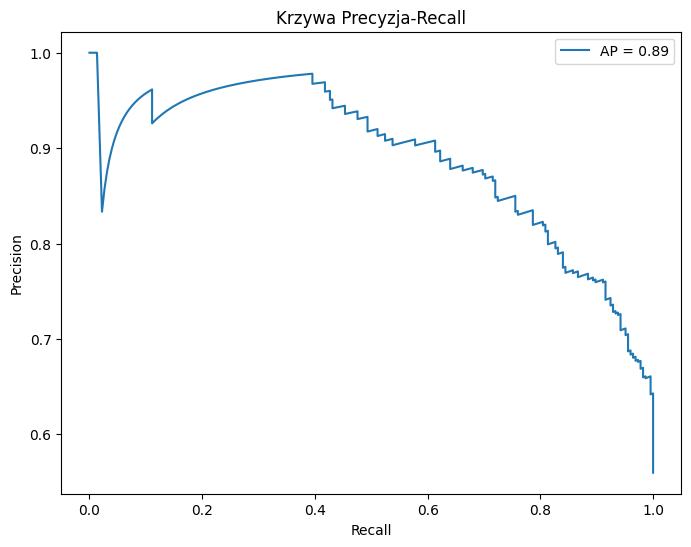

In [104]:
best_rf = bayes_search.best_estimator_
best_rf = evaluate_model(best_rf, X_train, y_train, X_test, y_test, cv_strategy, scoring)


### Analiza ważności cech


=== Analiza ważności cech ===


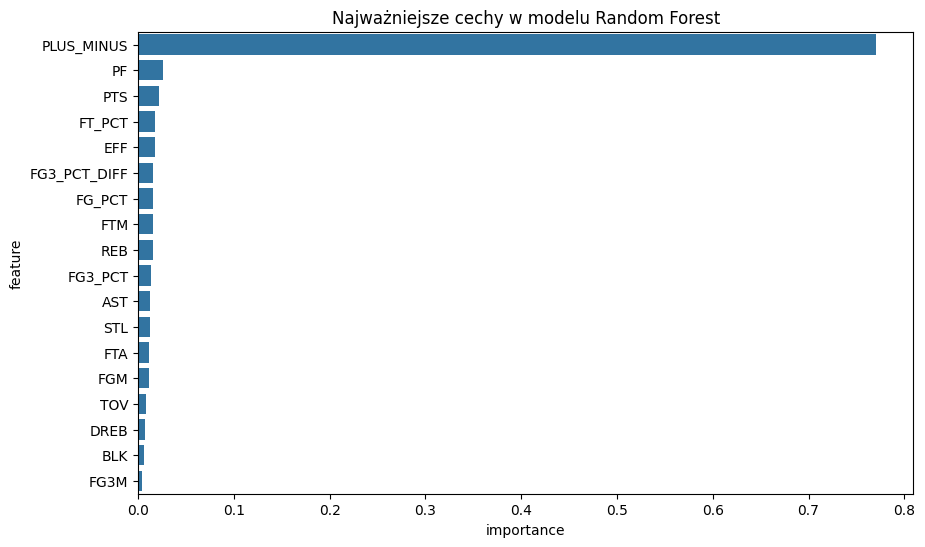

In [105]:
print("\n=== Analiza ważności cech ===")

# Pobranie nazw wybranych cech
selected_features = X.columns[best_rf.named_steps['preprocessing'].named_steps['feature_selector'].get_support()]

# Pobranie ważności cech
feature_importances = best_rf.named_steps['classifier'].feature_importances_

# Tworzenie DataFrame
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Najważniejsze cechy w modelu Random Forest')
plt.show()

### Analiza wpływu liczby cech i analiza ROC AUC

In [106]:
print("\n=== Analiza wpływu liczby cech na dokładność modelu ===")

k_values = list(range(7, len(X.columns) + 1))  
accuracies = []
roc_auc_scores = []

for k in k_values:
    pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
    ])
    
    # Walidacja krzyżowa
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_strategy, scoring='accuracy')
    mean_accuracy = np.mean(cv_scores)
    accuracies.append(mean_accuracy)
    
    # Obliczenie ROC AUC
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    roc_auc_scores.append(roc_auc)
    
    print(f"Liczba cech: {k:2d}, Dokładność (CV): {mean_accuracy:.4f}, ROC AUC: {roc_auc:.4f}")



=== Analiza wpływu liczby cech na dokładność modelu ===
Liczba cech:  7, Dokładność (CV): 0.7609, ROC AUC: 0.8686
Liczba cech:  8, Dokładność (CV): 0.7572, ROC AUC: 0.8651
Liczba cech:  9, Dokładność (CV): 0.7584, ROC AUC: 0.8669
Liczba cech: 10, Dokładność (CV): 0.7652, ROC AUC: 0.8612
Liczba cech: 11, Dokładność (CV): 0.7615, ROC AUC: 0.8635
Liczba cech: 12, Dokładność (CV): 0.7609, ROC AUC: 0.8625
Liczba cech: 13, Dokładność (CV): 0.7584, ROC AUC: 0.8692
Liczba cech: 14, Dokładność (CV): 0.7634, ROC AUC: 0.8642
Liczba cech: 15, Dokładność (CV): 0.7509, ROC AUC: 0.8662
Liczba cech: 16, Dokładność (CV): 0.7640, ROC AUC: 0.8709
Liczba cech: 17, Dokładność (CV): 0.7640, ROC AUC: 0.8682
Liczba cech: 18, Dokładność (CV): 0.7671, ROC AUC: 0.8667
Liczba cech: 19, Dokładność (CV): 0.7690, ROC AUC: 0.8646
Liczba cech: 20, Dokładność (CV): 0.7634, ROC AUC: 0.8649
Liczba cech: 21, Dokładność (CV): 0.7603, ROC AUC: 0.8726
Liczba cech: 22, Dokładność (CV): 0.7559, ROC AUC: 0.8643
Liczba cech: 23

#### Wykres wpływu liczby cech

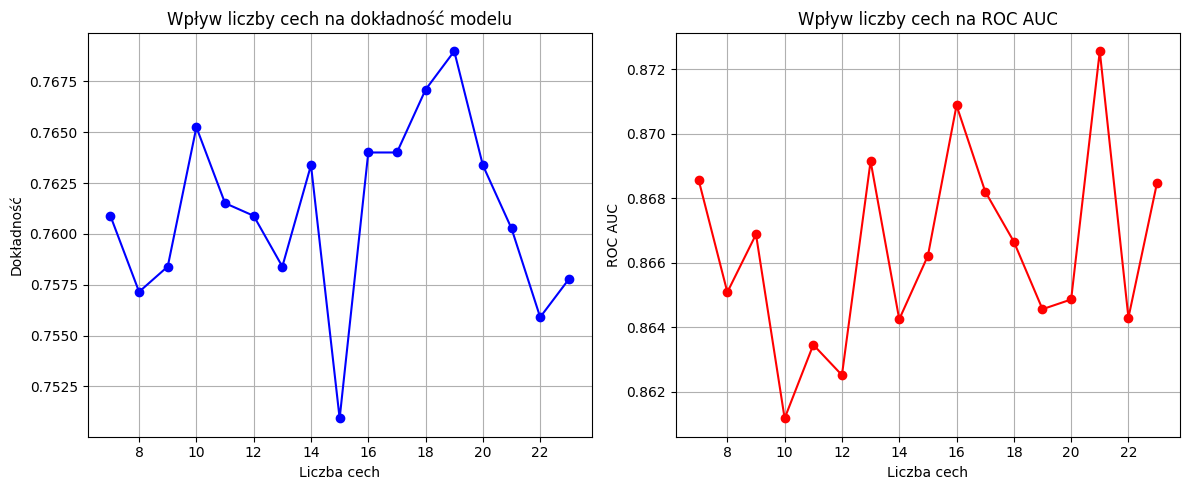

In [107]:
plt.figure(figsize=(12, 5))

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o', color='b', label='Dokładność (CV)')
plt.xlabel('Liczba cech')
plt.ylabel('Dokładność')
plt.title('Wpływ liczby cech na dokładność modelu')
plt.grid(True)

# Wykres ROC AUC
plt.subplot(1, 2, 2)
plt.plot(k_values, roc_auc_scores, marker='o', color='r', label='ROC AUC')
plt.xlabel('Liczba cech')
plt.ylabel('ROC AUC')
plt.title('Wpływ liczby cech na ROC AUC')
plt.grid(True)

plt.tight_layout()
plt.show()



### Analiza wrażliwości modelu na różne progi klasyfikacji

In [108]:
print("\n=== Analiza wrażliwości modelu na różne progi klasyfikacji ===")

# Najpierw trenujemy model z optymalną liczbą cech
best_k = k_values[np.argmax(roc_auc_scores)]
print(f"\nOptymalna liczba cech: {best_k}")

final_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('feature_selector', SelectKBest(score_func=f_classif, k=best_k)),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

final_pipeline.fit(X_train, y_train)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Testowanie różnych progów klasyfikacji
thresholds = np.linspace(0.1, 0.9, 9)
results = []

for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Threshold': thresh,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

# Konwersja wyników do DataFrame
threshold_results = pd.DataFrame(results)


=== Analiza wrażliwości modelu na różne progi klasyfikacji ===

Optymalna liczba cech: 21


#### Wykres metryk vs próg klasyfikacji

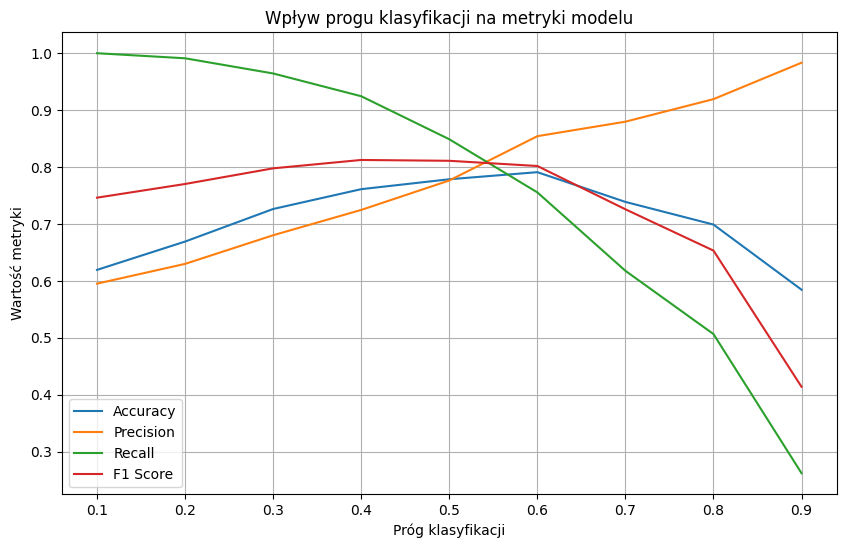


Optymalny próg klasyfikacji dla: 0.40
Metryki dla optymalnego progu:
Threshold    0.400000
Accuracy     0.761194
Precision    0.724739
Recall       0.924444
F1           0.812500
Name: 3, dtype: float64


In [109]:
plt.figure(figsize=(10, 6))
plt.plot(threshold_results['Threshold'], threshold_results['Accuracy'], label='Accuracy')
plt.plot(threshold_results['Threshold'], threshold_results['Precision'], label='Precision')
plt.plot(threshold_results['Threshold'], threshold_results['Recall'], label='Recall')
plt.plot(threshold_results['Threshold'], threshold_results['F1'], label='F1 Score')
plt.xlabel('Próg klasyfikacji')
plt.ylabel('Wartość metryki')
plt.title('Wpływ progu klasyfikacji na metryki modelu')
plt.legend()
plt.grid(True)
plt.show()

# Znalezienie optymalnego progu dla F1
optimal_idx = np.argmax(threshold_results['F1'])
optimal_threshold = threshold_results.iloc[optimal_idx]['Threshold']
print(f"\nOptymalny próg klasyfikacji dla: {optimal_threshold:.2f}")
print("Metryki dla optymalnego progu:")
print(threshold_results.iloc[optimal_idx])

### Analiza stabilności modelu poprzez bootstrap

In [110]:
print("\n=== Analiza stabilności modelu poprzez bootstrap ===")

n_iterations = 500
feature_importance_bootstrap = []

for _ in range(n_iterations):
    # Bootstrap sample
    X_sample, y_sample = resample(X_train, y_train, random_state=42)
    
    # Trenowanie modelu
    model = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_classif, k=best_k)),
        ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
    ])
    model.fit(X_sample, y_sample)
    
    # Pobranie ważności cech
    selected_features = X.columns[model.named_steps['feature_selector'].get_support()]
    importances = model.named_steps['classifier'].feature_importances_
    
    # Zapisz wyniki
    feature_importance_bootstrap.append(pd.Series(importances, index=selected_features))

# Agregacja wyników
importance_df = pd.concat(feature_importance_bootstrap, axis=1).T
mean_importance = importance_df.mean().sort_values(ascending=False)
std_importance = importance_df.std()[mean_importance.index]


=== Analiza stabilności modelu poprzez bootstrap ===


### Wykres ważności cech

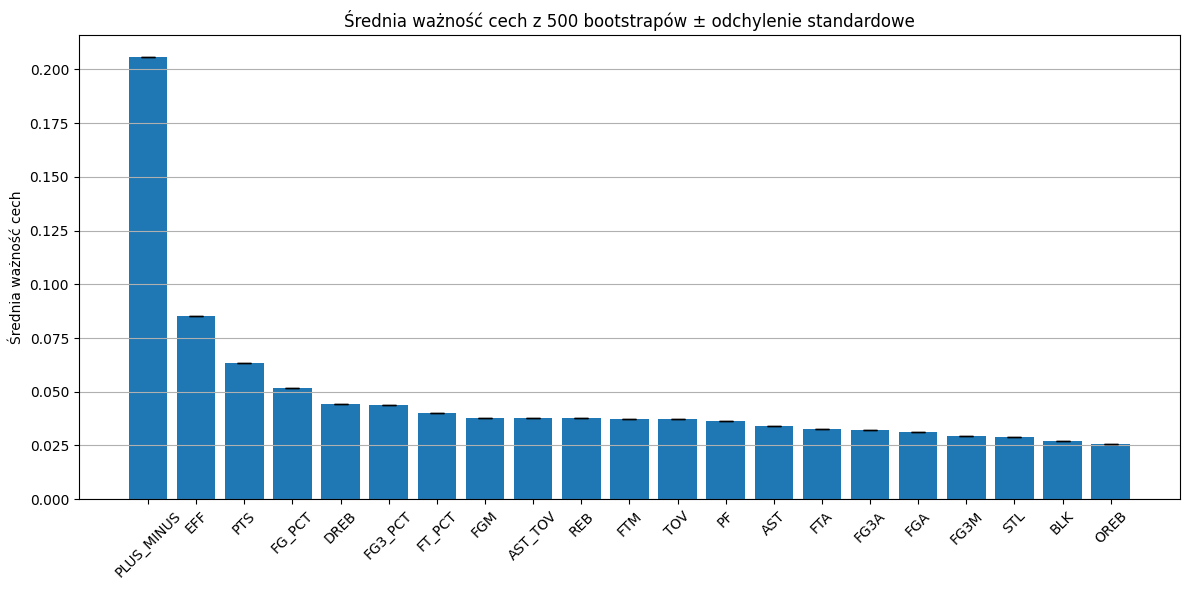

In [111]:
plt.figure(figsize=(12, 6))
plt.bar(mean_importance.index, mean_importance, yerr=std_importance, capsize=5)
plt.xticks(rotation=45)
plt.title('Średnia ważność cech z 500 bootstrapów ± odchylenie standardowe')
plt.ylabel('Średnia ważność cech')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### Krzywa uczenia


=== Krzywa uczenia ===


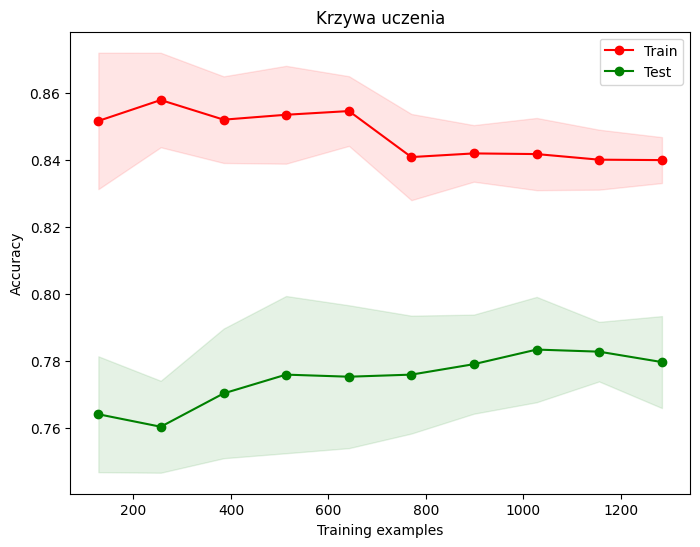

In [112]:
print("\n=== Krzywa uczenia ===")

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train, y_train, cv=cv_strategy, scoring='accuracy',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Krzywa uczenia")
plt.legend()
plt.show()

### Krzywa walidacji


=== Krzywa walidacji ===


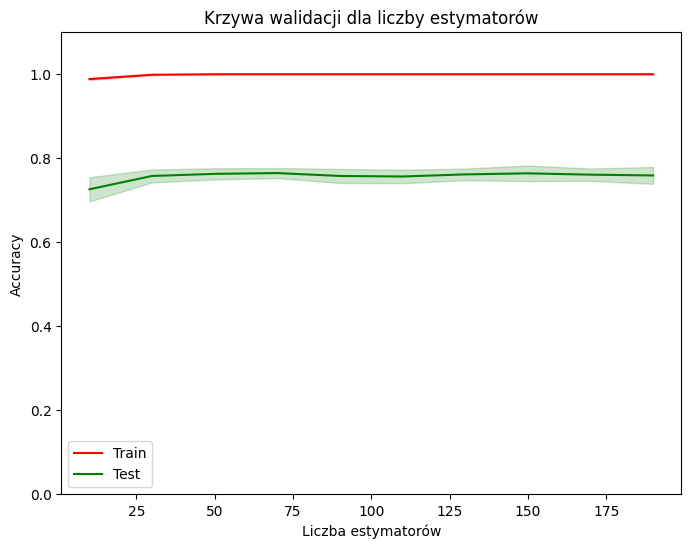

In [113]:
print("\n=== Krzywa walidacji ===")

param_range = np.arange(10, 200, 20)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42), X_train, y_train,
    param_name="n_estimators", param_range=param_range,
    cv=cv_strategy, scoring="accuracy", n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Krzywa walidacji dla liczby estymatorów")
plt.xlabel("Liczba estymatorów")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean, label="Train", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Test", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend()
plt.show()

#### Testy permutacyjne ważności cech


=== Testy permutacyjne ważności cech ===


C:\Users\Mateusz\AppData\Local\Temp\ipykernel_8096\3844662543.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T,


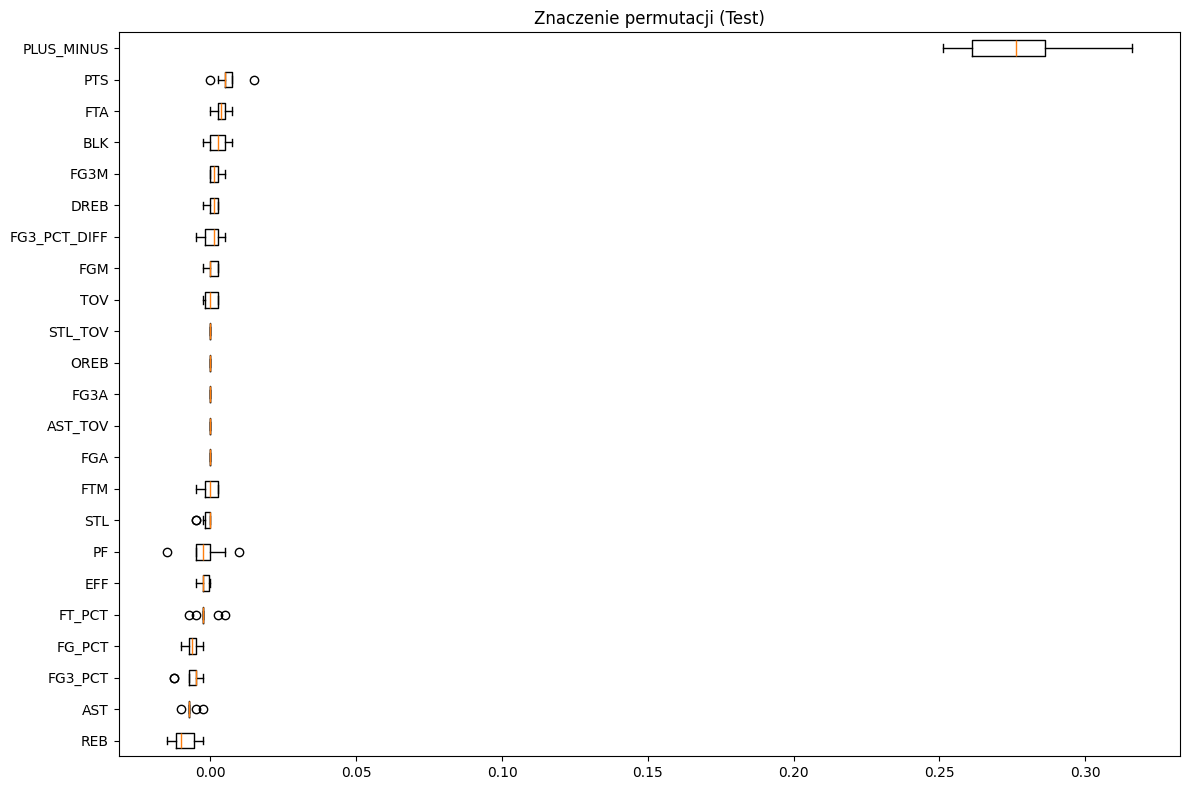

In [114]:
print("\n=== Testy permutacyjne ważności cech ===")

result = permutation_importance(best_rf, X_test, y_test, n_repeats=10, 
                               random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(12, 8))
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X_test.columns[sorted_idx])
plt.title("Znaczenie permutacji (Test)")
plt.tight_layout()
plt.show()

### Bootstrapowanie wyników modelu


=== Bootstrapowanie wyników modelu ===


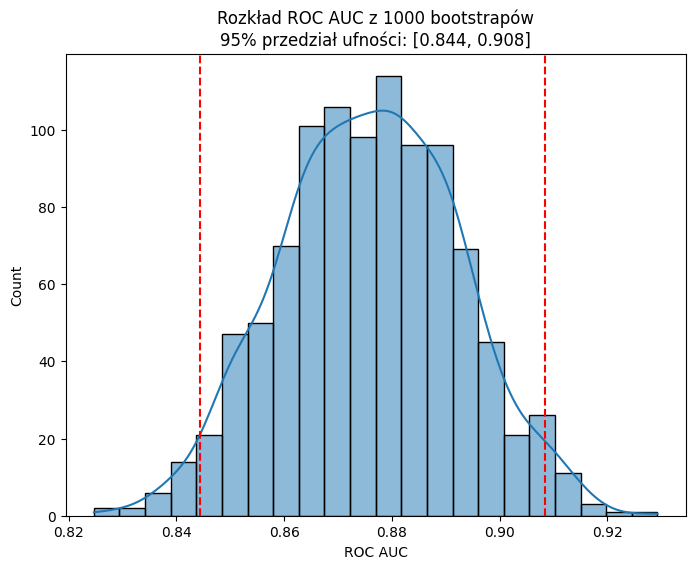

In [115]:
print("\n=== Bootstrapowanie wyników modelu ===")

n_bootstraps = 1000
bootstrapped_scores = []

for _ in range(n_bootstraps):
    X_sample, y_sample = resample(X_test, y_test, replace=True)
    y_proba = best_rf.predict_proba(X_sample)[:, 1]
    score = roc_auc_score(y_sample, y_proba)
    bootstrapped_scores.append(score)

plt.figure(figsize=(8, 6))
sns.histplot(bootstrapped_scores, kde=True)
plt.axvline(np.percentile(bootstrapped_scores, 2.5), color='r', linestyle='--')
plt.axvline(np.percentile(bootstrapped_scores, 97.5), color='r', linestyle='--')
plt.title(f"Rozkład ROC AUC z {n_bootstraps} bootstrapów\n95% przedział ufności: "
          f"[{np.percentile(bootstrapped_scores, 2.5):.3f}, "
          f"{np.percentile(bootstrapped_scores, 97.5):.3f}]")
plt.xlabel("ROC AUC")
plt.show()


### Kalibracja modelu

In [116]:
print("\n=== Kalibracja modelu ===")


=== Kalibracja modelu ===


#### Krzywa kalibracji

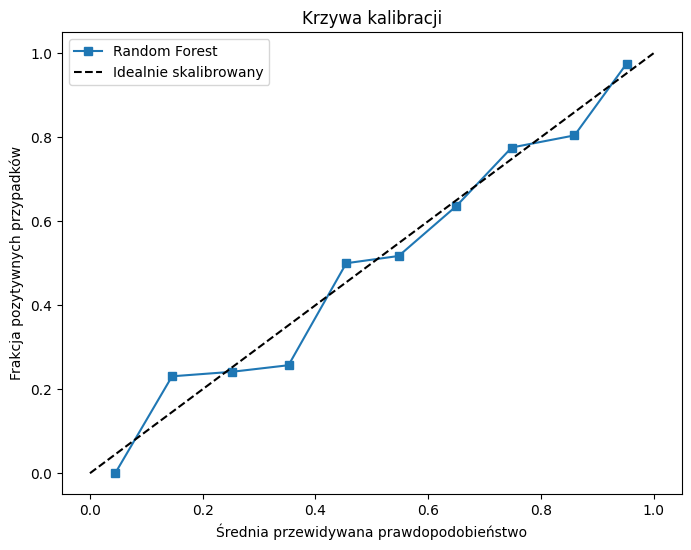

In [117]:
prob_true, prob_pred = calibration_curve(y_test, best_rf.predict_proba(X_test)[:, 1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, 's-', label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Idealnie skalibrowany')
plt.xlabel('Średnia przewidywana prawdopodobieństwo')
plt.ylabel('Frakcja pozytywnych przypadków')
plt.title('Krzywa kalibracji')
plt.legend()
plt.show()

#### Kalibracja modelu

c:\Users\Mateusz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


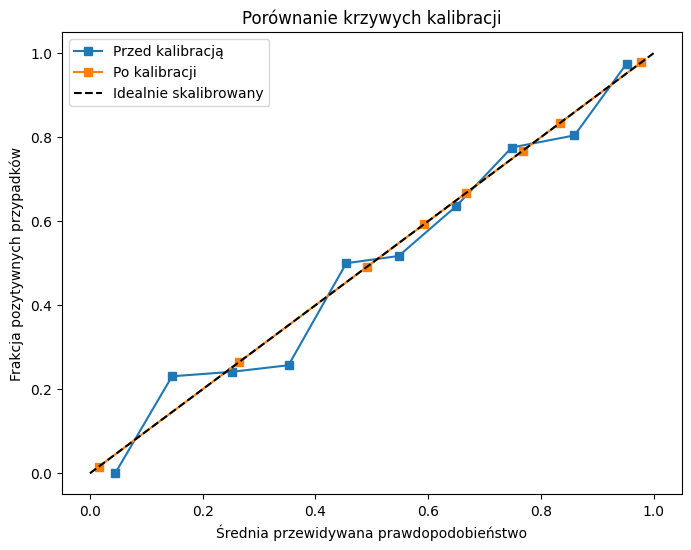


=== Ocena skalibrowanego modelu ===
Test accuracy: 0.7935


In [118]:
calibrated_rf = CalibratedClassifierCV(best_rf, cv='prefit', method='isotonic')
calibrated_rf.fit(X_test, y_test)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_rf.predict_proba(X_test)[:, 1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, 's-', label='Przed kalibracją')
plt.plot(prob_pred_cal, prob_true_cal, 's-', label='Po kalibracji')
plt.plot([0, 1], [0, 1], 'k--', label='Idealnie skalibrowany')
plt.xlabel('Średnia przewidywana prawdopodobieństwo')
plt.ylabel('Frakcja pozytywnych przypadków')
plt.title('Porównanie krzywych kalibracji')
plt.legend()
plt.show()

# Ocena skalibrowanego modelu
print("\n=== Ocena skalibrowanego modelu ===")
test_score = calibrated_rf.score(X_test, y_test)
print(f"Test accuracy: {test_score:.4f}")

### Budowa zespołu modeli

### Analiza błędów

In [119]:
print("\n=== Budowa zespołu modeli (Ensemble) ===")

# Definicja modeli w zespole
estimators = [
    ('rf', best_rf),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]


=== Budowa zespołu modeli (Ensemble) ===


In [120]:
scoring_v2 = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

#### Voting Classifier - twarde głosowanie


=== Ocena modelu VotingClassifier ===

Wyniki walidacji krzyżowej:
accuracy: 0.7796 ± 0.0151
precision: 0.7975 ± 0.0109
recall: 0.8115 ± 0.0306
f1: 0.8041 ± 0.0165

Metryki na zbiorze testowym:
Czas trenowania: 1.21s
Accuracy: 0.7886
Precision: 0.8017
Recall: 0.8267
F1: 0.8140


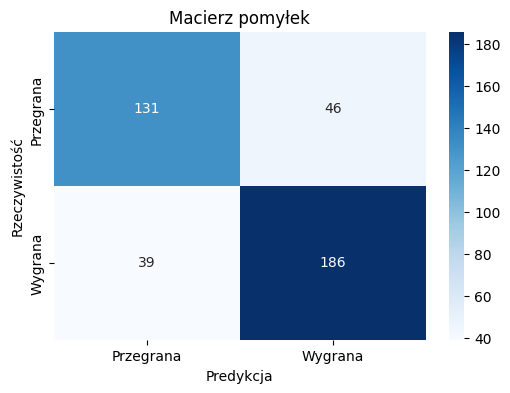

In [121]:
voting_clf_hard = VotingClassifier(estimators=estimators, voting='hard')
voting_clf_hard = evaluate_model(voting_clf_hard, X_train, y_train, X_test, y_test, cv_strategy, scoring_v2)

#### Voting Classifier - miękkie głosowanie


=== Ocena modelu VotingClassifier ===

Wyniki walidacji krzyżowej:
accuracy: 0.7820 ± 0.0187
precision: 0.8017 ± 0.0164
recall: 0.8104 ± 0.0267
f1: 0.8058 ± 0.0181

Metryki na zbiorze testowym:
Czas trenowania: 1.19s
Accuracy: 0.8010
Precision: 0.8139
Recall: 0.8356
F1: 0.8246
ROC AUC: 0.8820
Log Loss: 0.4249
Brier Score: 0.1384


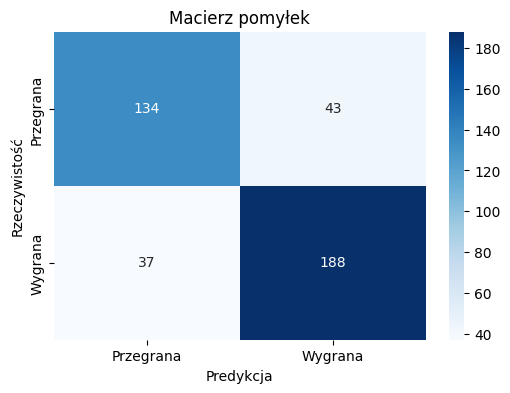

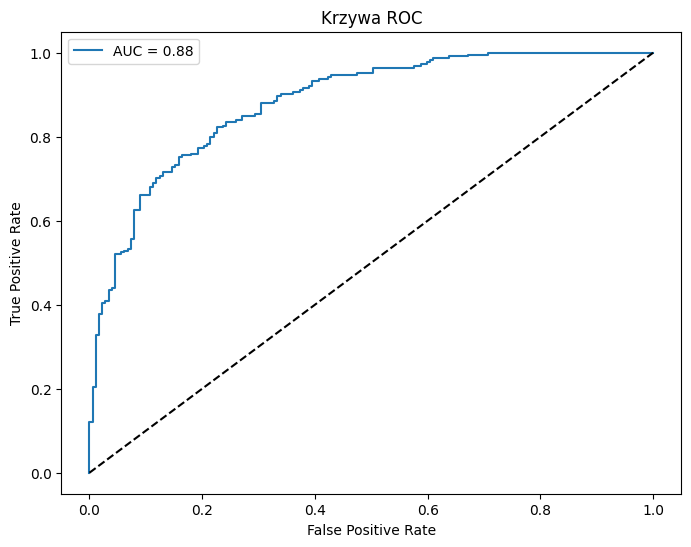

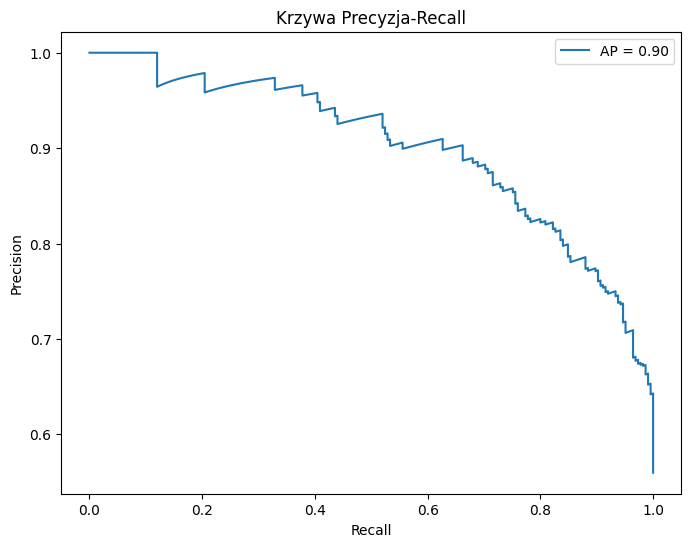

In [122]:
voting_clf_soft = VotingClassifier(estimators=estimators, voting='soft')
voting_clf_soft = evaluate_model(voting_clf_soft, X_train, y_train, X_test, y_test, cv_strategy, scoring_v2)

#### Stacking Classifier


=== Ocena modelu StackingClassifier ===

Wyniki walidacji krzyżowej:
accuracy: 0.7821 ± 0.0144
precision: 0.7993 ± 0.0144
recall: 0.8149 ± 0.0303
f1: 0.8066 ± 0.0154
roc_auc: 0.8634 ± 0.0123
log_loss: -0.4636 ± 0.0208

Metryki na zbiorze testowym:
Czas trenowania: 6.41s
Accuracy: 0.7935
Precision: 0.8008
Recall: 0.8400
F1: 0.8200
ROC AUC: 0.8822
Log Loss: 0.4338
Brier Score: 0.1395


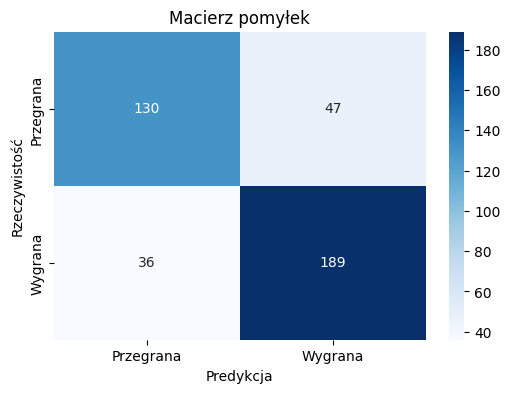

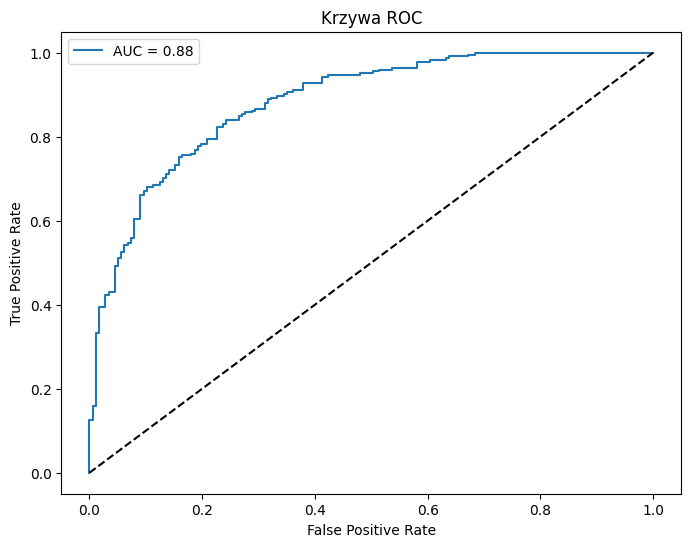

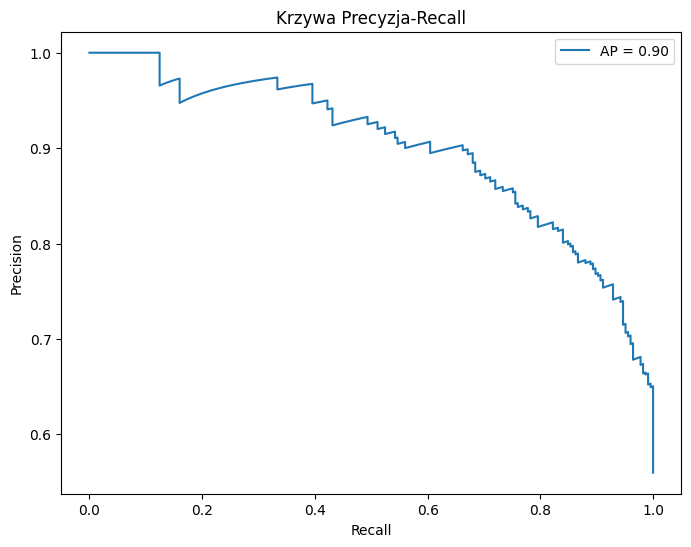

In [123]:
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=cv_strategy
)
stacking_clf = evaluate_model(stacking_clf, X_train, y_train, X_test, y_test, cv_strategy, scoring)


=== Analiza błędów ===

Statystyki błędnych predykcji:
Liczba błędów: 86/402 (21.39%)

Najbardziej pewne błędne predykcje:
      true_label  predicted_label  predicted_prob
506            0                1        0.981565
209            0                1        0.974143
1004           0                1        0.885114
38             0                1        0.875592
1943           0                1        0.871241
532            0                1        0.864379
94             0                1        0.858019
1862           0                1        0.846871
793            0                1        0.824252
22             0                1        0.821427


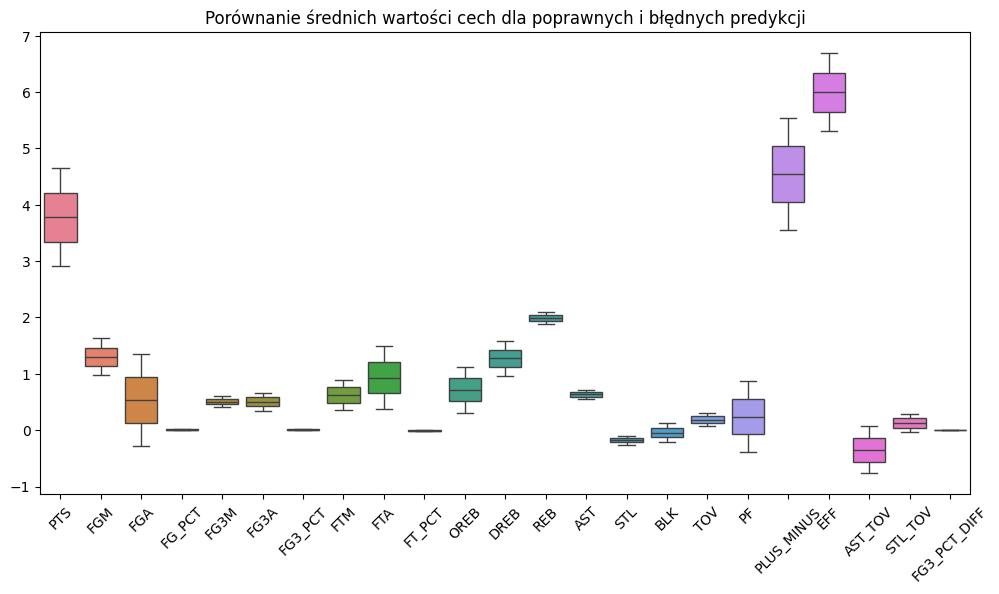

In [124]:
print("\n=== Analiza błędów ===")

# Predykcje na zbiorze testowym
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Znajdź błędnie sklasyfikowane przypadki
wrong_idx = np.where(y_pred != y_test)[0]
wrong_samples = X_test.iloc[wrong_idx].copy()
wrong_samples['true_label'] = y_test.iloc[wrong_idx]
wrong_samples['predicted_label'] = y_pred[wrong_idx]
wrong_samples['predicted_prob'] = y_proba[wrong_idx]

# Analiza błędnych predykcji
print("\nStatystyki błędnych predykcji:")
print(f"Liczba błędów: {len(wrong_idx)}/{len(y_test)} ({len(wrong_idx)/len(y_test):.2%})")

# Najbardziej mylące przypadki (wysokie prawdopodobieństwo, ale błędna predykcja)
most_confident_errors = wrong_samples.sort_values('predicted_prob', ascending=False).head(10)
print("\nNajbardziej pewne błędne predykcje:")
print(most_confident_errors[['true_label', 'predicted_label', 'predicted_prob']])

# Analiza różnic między błędnymi a poprawnymi predykcjami
plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.concat([
    X_test[y_test == y_pred].mean().rename('Poprawne'),
    X_test[y_test != y_pred].mean().rename('Błędne')
], axis=1).T)
plt.title('Porównanie średnich wartości cech dla poprawnych i błędnych predykcji')
plt.xticks(rotation=45)
plt.show()

#### Testowanie na nowych danych (następny sezon)

In [125]:
print("\n=== Testowanie na nowych danych ===")

# Pobieranie danych z nowego sezonu
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2023-24')
new_games = gamefinder.get_data_frames()[0]

# Przygotowanie nowych danych w taki sam sposób
new_games_clean = new_games.copy()
new_games_clean['WL'] = new_games_clean['WL'].apply(lambda x: 1 if x == 'W' else 0)

new_home = new_games_clean[new_games_clean['MATCHUP'].str.contains('vs.')].sort_values('GAME_DATE')
new_away = new_games_clean[new_games_clean['MATCHUP'].str.contains('@')].sort_values('GAME_DATE')

new_home_stats = new_home[features]
new_away_stats = new_away[features]

new_diff_stats = new_home_stats.reset_index(drop=True) - new_away_stats.reset_index(drop=True)
new_diff_stats['WL'] = new_home['WL'].reset_index(drop=True)

# Tworzenie dodatkowych cech
new_diff_stats['EFF'] = (new_diff_stats['PTS'] + new_diff_stats['REB'] + new_diff_stats['AST'] +
                        new_diff_stats['STL'] + new_diff_stats['BLK'] - new_diff_stats['TOV'])
new_diff_stats['AST_TOV'] = new_diff_stats['AST'] / (new_diff_stats['TOV'] + 1)
new_diff_stats['STL_TOV'] = new_diff_stats['STL'] / (new_diff_stats['TOV'] + 1)
new_diff_stats['FG3_PCT_DIFF'] = new_diff_stats['FG3_PCT'] - new_diff_stats['FG_PCT']

# Czyszczenie danych
new_diff_stats.replace([np.inf, -np.inf], np.nan, inplace=True)
new_diff_stats.dropna(inplace=True)

# Przygotowanie danych do predykcji
X_new = new_diff_stats.drop('WL', axis=1)
y_new = new_diff_stats['WL']

# Ocena modelu na nowych danych
print("\n=== Ocena modelu na danych z nowego sezonu ===")
y_pred_new = best_rf.predict(X_new)
y_proba_new = best_rf.predict_proba(X_new)[:, 1]

print("\nMetryki na nowych danych:")
print(f"Accuracy: {accuracy_score(y_new, y_pred_new):.4f}")
print(f"Precision: {precision_score(y_new, y_pred_new):.4f}")
print(f"Recall: {recall_score(y_new, y_pred_new):.4f}")
print(f"F1: {f1_score(y_new, y_pred_new):.4f}")
print(f"ROC AUC: {roc_auc_score(y_new, y_proba_new):.4f}")

# Porównanie wydajności między sezonami
performance_comparison = pd.DataFrame({
    'Sezon 2022-23': [
        accuracy_score(y_test, best_rf.predict(X_test)),
        precision_score(y_test, best_rf.predict(X_test)),
        recall_score(y_test, best_rf.predict(X_test)),
        f1_score(y_test, best_rf.predict(X_test)),
        roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
    ],
    'Sezon 2023-24': [
        accuracy_score(y_new, y_pred_new),
        precision_score(y_new, y_pred_new),
        recall_score(y_new, y_pred_new),
        f1_score(y_new, y_pred_new),
        roc_auc_score(y_new, y_proba_new)
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])

print("\nPorównanie wydajności między sezonami:")
print(performance_comparison)


=== Testowanie na nowych danych ===

=== Ocena modelu na danych z nowego sezonu ===

Metryki na nowych danych:
Accuracy: 0.7604
Precision: 0.7919
Recall: 0.7663
F1: 0.7789
ROC AUC: 0.8382

Porównanie wydajności między sezonami:
           Sezon 2022-23  Sezon 2023-24
Accuracy        0.786070       0.760355
Precision       0.806167       0.791859
Recall          0.813333       0.766338
F1              0.809735       0.778890
ROC AUC         0.875756       0.838210


### Przygotowanie do deploymentu

In [126]:
print("\n=== Przygotowanie do deploymentu ===")


=== Przygotowanie do deploymentu ===


#### zapis modelu

In [127]:
joblib.dump(best_rf, 'nba_game_predictor.pkl')

['nba_game_predictor.pkl']

#### Funkcja predykcyjna

In [128]:
def predict_game_outcome(home_stats, away_stats):
    try:
        # Konwersja na DataFrame jeśli potrzeba
        if isinstance(home_stats, dict):
            home_stats = pd.Series(home_stats)
        if isinstance(away_stats, dict):
            away_stats = pd.Series(away_stats)
        
        # Obliczenie różnic statystyk
        diff_stats = home_stats[features] - away_stats[features]
        diff_stats = pd.DataFrame([diff_stats])  
        
        # Obliczenie dodatkowych cech
        diff_stats['EFF'] = (diff_stats['PTS'] + diff_stats['REB'] + diff_stats['AST'] +
                             diff_stats['STL'] + diff_stats['BLK'] - diff_stats['TOV'])
        
        # Bezpieczne obliczenia dla współczynników (zabezpieczenie przed dzieleniem przez zero)
        diff_stats['AST_TOV'] = np.where(diff_stats['TOV'] != 0, 
                                        diff_stats['AST'] / (diff_stats['TOV'] + 1), 
                                        0)
        diff_stats['STL_TOV'] = np.where(diff_stats['TOV'] != 0, 
                                        diff_stats['STL'] / (diff_stats['TOV'] + 1), 
                                        0)
        diff_stats['FG3_PCT_DIFF'] = diff_stats['FG3_PCT'] - diff_stats['FG_PCT']
        
        # Zastąpienie nieskończoności i NaN
        diff_stats.replace([np.inf, -np.inf], np.nan, inplace=True)
        diff_stats.fillna(0, inplace=True)
        
        # Upewnij się, że kolumny są w tej samej kolejności co podczas trenowania
        diff_stats = diff_stats[X_train.columns]
        
        # Predykcja
        win_prob = best_rf.predict_proba(diff_stats)[0, 1]
        
        return {
            'predicted_outcome': 'Wygrana gospodarzy' if win_prob > 0.5 else 'Wygrana gości',
            'win_probability': float(win_prob),
            'confidence': 'Wysoka' if (win_prob > 0.7 or win_prob < 0.3) else 'Średnia' if (win_prob > 0.6 or win_prob < 0.4) else 'Niska'
        }
    
    except Exception as e:
        print(f"Błąd podczas predykcji: {str(e)}")
        return {
            'predicted_outcome': 'Błąd predykcji',
            'win_probability': 0.5,
            'confidence': 'Niska'
        }

#### Przykładowe użycie funkcji predykcyjnej

In [130]:
# Przykładowe użycie - teraz z dodatkowym sprawdzeniem danych
sample_away = X_test.iloc[1][features].to_dict()
sample_home = X_test.iloc[0][features].to_dict()

# Sprawdźmy, czy nie ma problemów z przykładowymi danymi
print("\nSprawdzenie przykładowych danych:")
print("Home stats:", sample_home)
print("Away stats:", sample_away)

# Sprawdźmy różnice statystyk
diff_check = {k: sample_home[k] - sample_away[k] for k in features}
print("\nRóżnice statystyk:", diff_check)

print("\nPrzykładowa predykcja:")
print(predict_game_outcome(sample_home, sample_away))


Sprawdzenie przykładowych danych:
Home stats: {'PTS': 24.0, 'FGM': 13.0, 'FGA': 14.0, 'FG_PCT': 0.07300000000000001, 'FG3M': -2.0, 'FG3A': 5.0, 'FG3_PCT': -0.08899999999999997, 'FTM': 0.0, 'FTA': 1.0, 'FT_PCT': -0.03700000000000003, 'OREB': 3.0, 'DREB': 3.0, 'REB': 6.0, 'AST': 0.0, 'STL': 1.0, 'BLK': 2.0, 'TOV': -7.0, 'PF': 6.0, 'PLUS_MINUS': 34.0}
Away stats: {'PTS': -19.0, 'FGM': -8.0, 'FGA': -21.0, 'FG_PCT': 0.029000000000000026, 'FG3M': 3.0, 'FG3A': 6.0, 'FG3_PCT': 0.03500000000000003, 'FTM': -14.0, 'FTA': -14.0, 'FT_PCT': -0.11699999999999999, 'OREB': -1.0, 'DREB': -9.0, 'REB': -10.0, 'AST': -4.0, 'STL': 3.0, 'BLK': -1.0, 'TOV': 17.0, 'PF': -7.0, 'PLUS_MINUS': -9.0}

Różnice statystyk: {'PTS': 43.0, 'FGM': 21.0, 'FGA': 35.0, 'FG_PCT': 0.043999999999999984, 'FG3M': -5.0, 'FG3A': -1.0, 'FG3_PCT': -0.124, 'FTM': 14.0, 'FTA': 15.0, 'FT_PCT': 0.07999999999999996, 'OREB': 4.0, 'DREB': 12.0, 'REB': 16.0, 'AST': 4.0, 'STL': -2.0, 'BLK': 3.0, 'TOV': -24.0, 'PF': 13.0, 'PLUS_MINUS': 43.0}
